# Aufgabe 1

Erweitern Sie die Klasse `WGS84Coord` aus der Uebung 3:<br/>

Zwei neue Methoden sollen hinzugefügt werden:

`toLV95()` : gibt eine die Koordinate als LV95 zurück (E,N) <br/>

`fromLV95(E,N)`: setzt die WGS84 Koordinate aus LV95 

Es soll pyproj verwendet werden.

**Unsere Hilfefunktionen (Übung 3)**

In [85]:
from geoutils import check_latitude, check_longitude

In [86]:
# test mit Daten
check_latitude(1231321)

/Users/matus/Dropbox/FHNW/Lehre/PR2/HS2021/Programmierung2/Kapitel_10/Uebung_10_Loesung/geoutils.py:26: UserWarning: The latitude value 1231321 either too small or too large. Wrapping it into the interval [-90, 90]
  warnings.warn(f"The latitude value {lat} either too small or too large."


-59

## 1) Ineffektive Lösung
- `pyproj.Transformer` object in `to_LV95()` instanziert, jedes mal wenn diese aufgerufen wird 

In [87]:
from pyproj import Transformer


class WGS84Coord:
    def __init__(self, latitude=0, longitude=0):
        self.longitude = longitude
        self.latitude = latitude
        self._n_calls_Transformer_from_crs = 0      # how many times have we instantiated the Transformer obj.?

    def __repr__(self):
        return f"{type(self).__name__}(lat={self.latitude:.7f},lon={self.longitude:.7f})"

    def _set_longitude(self, longitude):
        self._longitude = check_longitude(longitude)

    def _get_longitude(self):
        return self._longitude

    def _set_latitude(self, latitude):
        self._latitude = check_latitude(latitude)
        
    def _get_latitude(self):
        return self._latitude 

    longitude = property(_get_longitude, _set_longitude)
    latitude = property(_get_latitude, _set_latitude)

    def to_LV95(self):
        trans = Transformer.from_crs("EPSG:4326","EPSG:2056")
        self._n_calls_Transformer_from_crs += 1
        
        return trans.transform(self.latitude, self.longitude)
        
    def from_LV95(self, E, N):
        trans = Transformer.from_crs("EPSG:2056", "EPSG:4326")
        self._n_calls_Transformer_from_crs += 1
        
        self.latitude, self.longitude = trans.transform(E, N)

In [88]:
FHNW_wgs84 = 47.5348685, 7.6419605
FHNW_lv95 = 2615311.0, 1264924.0

wgs84coord = WGS84Coord(*FHNW_wgs84)
wgs84coord

WGS84Coord(lat=47.5348685,lon=7.6419605)

In [89]:
print(wgs84coord.to_LV95())

wgs84coord.latitude, wgs84coord.latitude = 0, 0
print(wgs84coord.to_LV95())     # Unsinn, müssen später beheben...

wgs84coord.from_LV95(*FHNW_lv95)
print(wgs84coord)
print()

(2615310.999138606, 1264924.0013158186)
(2633007.172850471, -4699599.679838558)
WGS84Coord(lat=47.5348685,lon=7.6419605)



Wie oft haben wir `pyproj.Transformer.from_crs()` aufgerufen?
- beim jeden Aufruf von `to_LV95` oder `from_LV95` generieren wir eine neue Instanz von `pyproj.Trannsformer`

In [90]:
wgs84coord._n_calls_Transformer_from_crs

3

## 2) Effektivere Lösung
- Konstruktion von `Transformer()` Objekt geschieht nur einmal in `__init__()`
- `Transformer` Objekt wird als Attribut der Klasse gespeichert
- nutzen wir die Tatsache aus, dass der `Transformer` in beide Richtugen rechnen kann:
    - source_crs --> dest_crs:
    ```python
    trans.transform(lat, lon)
    ```
    - dest_crs --> source_crs:
    ```python
    trans.transform(E, N, direction=TransformDirection.INVERSE)
    ```

In [91]:
from pyproj import Transformer
from pyproj.enums import TransformDirection


class WGS84Coord2:
    def __init__(self, latitude=0, longitude=0):
        self.longitude = longitude
        self.latitude = latitude
        self._trans = Transformer.from_crs("EPSG:4326","EPSG:2056")

    def __repr__(self):
        return f"{type(self).__name__}(lat={self.latitude:.7f},lon={self.longitude:.7f})"

    def _set_longitude(self, longitude):
        self._longitude = check_longitude(longitude)

    def _get_longitude(self):
        return self._longitude

    def _set_latitude(self, latitude):
        self._latitude = check_latitude(latitude)
        
    def _get_latitude(self):
        return self._latitude 

    longitude = property(_get_longitude, _set_longitude)
    latitude = property(_get_latitude, _set_latitude)

    def to_LV95(self):
        return self._trans.transform(self.latitude, self.longitude)
        
    def from_LV95(self, E, N):
        self.latitude, self.longitude = self._trans.transform(
            E, N, direction=TransformDirection.INVERSE)

In [92]:
wgs84coord = WGS84Coord(*FHNW_wgs84)
wgs84coord2 = WGS84Coord2(*FHNW_wgs84)

print(wgs84coord)
print(wgs84coord2)

WGS84Coord(lat=47.5348685,lon=7.6419605)
WGS84Coord2(lat=47.5348685,lon=7.6419605)


In [93]:
print(wgs84coord.to_LV95())
print(wgs84coord2.to_LV95())

(2615310.999138606, 1264924.0013158186)
(2615310.999138606, 1264924.0013158186)


**Performance Vergleich** 
- mit `%timeit` [Magic Funktion](https://ipython.readthedocs.io/en/stable/interactive/magics.html)
- `-r` Option: reapeats
- `-o` Option: das Ergebnise als Wert ausgeben, dass wir in eine Python Variable schreiben könne

In [95]:
wgs84coord_time = %timeit -r 10 -o wgs84coord.to_LV95()  

9.25 ms ± 281 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [96]:
wgs84coord2_time = %timeit -r 10 -o wgs84coord2.to_LV95()

6.7 µs ± 465 ns per loop (mean ± std. dev. of 10 runs, 100000 loops each)


In [97]:
print(f"{wgs84coord_time.average / wgs84coord2_time.average:.1f} mal schneller!!!")

1382.1 mal schneller!!!


## 3) Noch effektivere Lösung (advanced)
- nicht jede Instanz von `WGS84Coord` braucht einen eigenen `Transformer` Objekt
- 2 Möglichkeiten:
    - `Transformer` Objekt als eine **globale Variable** 
    - `Transformer` Objekt als **Klassenattribut** 
    
```python
class MyClass:
    cls_attr = "foo"  # class attribute is shared among all instances of the class
    
    def bar(self):
        return MyClass.cls_attr   # one way to use a class attribute in instance methods
    
    def baz(self):
        return self.cls_attr      # ... and another

my_class = MyClass()
print(my_class.bar())
print(my_class.baz())
```

In [98]:
from pyproj import Transformer
from pyproj.enums import TransformDirection


class WGS84Coord3:
    _trans = Transformer.from_crs("EPSG:4326","EPSG:2056")   # class attribute
    
    def __init__(self, latitude=0, longitude=0):
        self.longitude = longitude
        self.latitude = latitude

    def __repr__(self):
        return f"{type(self).__name__}(lat={self.latitude:.7f},lon={self.longitude:.7f})"

    def _set_longitude(self, longitude):
        self._longitude = check_longitude(longitude)

    def _get_longitude(self):
        return self._longitude

    def _set_latitude(self, latitude):
        self._latitude = check_latitude(latitude)
        
    def _get_latitude(self):
        return self._latitude 

    longitude = property(_get_longitude, _set_longitude)
    latitude = property(_get_latitude, _set_latitude)

    def to_LV95(self):
        return self._trans.transform(self.latitude, self.longitude)
        
    def from_LV95(self, E, N):
        self.latitude, self.longitude = self._trans.transform(
            E, N, direction=TransformDirection.INVERSE)

In [99]:
wgs84coord3 = WGS84Coord3(*FHNW_wgs84)
wgs84coord3

WGS84Coord3(lat=47.5348685,lon=7.6419605)

In [100]:
print(wgs84coord.to_LV95())
print(wgs84coord2.to_LV95())
print(wgs84coord3.to_LV95())

(2615310.999138606, 1264924.0013158186)
(2615310.999138606, 1264924.0013158186)
(2615310.999138606, 1264924.0013158186)


**Performance Vergleich** 

In [101]:
def run_on_10_objects_10_times(cls):
    for _ in range(10):
        obj = cls(*FHNW_wgs84)
        for _ in range(10):
            obj.to_LV95()

In [102]:
wgs84coord_time = %timeit -r 10 -o run_on_10_objects_10_times(WGS84Coord)
wgs84coord2_time = %timeit -r 10 -o run_on_10_objects_10_times(WGS84Coord2)
wgs84coord3_time = %timeit -r 10 -o run_on_10_objects_10_times(WGS84Coord3)

930 ms ± 31.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
109 ms ± 12.8 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
789 µs ± 201 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [60]:
print(f"WGS84Coord  speedup: {wgs84coord_time.average / wgs84coord_time.average:.1f}")
print(f"WGS84Coord2 speedup: {wgs84coord_time.average / wgs84coord2_time.average:.1f}")
print(f"WGS84Coord3 speedup: {wgs84coord_time.average / wgs84coord3_time.average:.1f}")

WGS84Coord  speedup: 1.0
WGS84Coord2 speedup: 9.9
WGS84Coord3 speedup: 1386.1


### Weitere Verbesserungen (advanced)
- Warnung wenn LV95 Koordinate angefragt werden außerhalb des vorgesehenen Geltungsbereichs
- `from_LV95` soll ein **alternativer Konstruktor** sein (ählich wie `Transformer.from_crs()`):
    - wird aufgerufen bevor überhaupt eine Klasseninstanz erstellt wird => wird als Klassenmethode implementiert
    - eine Klassenmethode in Python wird mit einem `@classmethod` "dekoriert"
    - bei einer Instanzmethode verwenden wir `self` als erstes Argument - die Methode hat dan Zugriff auf alle Instanzattribute und Methoden
    - bei einer Klassenmethode verwenden wir `cls` (reine Konvention) 
    - eine Klassenmethode hat keinen Zugriff auf Instanzattribute, kann aber Instanzen konstruieren
    - [Tutorial bei RealPython](https://realpython.com/instance-class-and-static-methods-demystified/)
- `longitude` and `latitude` properties mit einem `@property` **Decorator** implementieren
    - [Tutorial bei RealPython](https://realpython.com/python-property/)

In [103]:
import warnings
warnings.simplefilter('always', UserWarning)

from pyproj import CRS, Transformer
from pyproj.enums import TransformDirection


class WGS84Coord4:
    # class attributes
    _wgs84 = CRS.from_epsg(4326)
    _lv95 = CRS.from_epsg(2056)
    
    _trans = Transformer.from_crs(_wgs84, _lv95)
    _limit_W, _limit_S, _limit_E, _limit_N = _lv95.area_of_use.bounds   # Geltungsbereich
    
    def __init__(self, latitude=0, longitude=0):
        self.longitude = longitude
        self.latitude = latitude

    def __repr__(self):
        return f"{type(self).__name__}(lat={self.latitude:.7f},lon={self.longitude:.7f})"
    
    # Die Übliche Schreibeweise für `property` Attribuite in Python
    # ist mit einem Decorator `@property` für getter und `@myfunc.setter` für den setter
    # die Methode hat in beiden Fällen den gleichen Namen (myfunc)
    @property
    def longitude(self):
        return self._longitude
    
    @longitude.setter
    def longitude(self, longitude):
        self._longitude = check_longitude(longitude)
    
    @property
    def latitude(self):
        return self._latitude
    
    @latitude.setter
    def latitude(self, latitude):
        self._latitude = check_latitude(latitude)

    def to_LV95(self):
        # Is in den Geltungsbereich von LV95?
        if (self._limit_S <= self.latitude <= self._limit_N) and \
           (self._limit_W <= self.longitude <= self._limit_E):
            return self._trans.transform(self.latitude, self.longitude)
        else:
            warnings.warn(f"Die Lat/Lon Werte ({self.latitude}, {self.longitude}) sind außerhalb des Geltungsbereichs:\n"
                          f"{self._lv95.area_of_use}") 
        
    @classmethod
    def from_LV95(cls, E, N):
        lat, lon = cls._trans.transform(E, N, direction=TransformDirection.INVERSE)
        
        return cls(lat, lon)   # wird ersetzt durch: WGS84Coord4(lat, lon)

In [104]:
wgs84coord4 = WGS84Coord4(46, 5)

In [105]:
wgs84coord4.to_LV95()

/var/folders/8_/89sz7q3961n_2p6drnympl1w0000gn/T/ipykernel_33307/3311713442.py:48: UserWarning: Die Lat/Lon Werte (46, 5) sind außerhalb des Geltungsbereichs:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
  warnings.warn(f"Die Lat/Lon Werte ({self.latitude}, {self.longitude}) sind außerhalb des Geltungsbereichs:\n"


In [106]:
WGS84Coord4.from_LV95(*FHNW_lv95)

WGS84Coord4(lat=47.5348685,lon=7.6419605)

## Extras (Aufgabe 1)
- `numpy` support
- mit `np.vectorize(func)` kann man beliebige Funktion mit Skalar-Argumenten in eine vektorisierte Funktion umwandeln (die Arrays als Argumente erlaubt)
- `np.vectorize` benutzt aber intern eine For-Schleife, wenn man Performance braucht muss man alle beteiligte Funktionen in `numpy` umschreiben (gerne als Hausaufgabe versuchen) 
    - es geht nur um die Funktionen `check_longitude` und `check_latitude`

In [112]:
from typing import Iterable
import warnings
warnings.simplefilter('always', UserWarning)

import numpy as np

from pyproj import CRS, Transformer
from pyproj.enums import TransformDirection


class WGS84Coord5:
    crs = CRS.from_epsg(4326)
    _crs_lv95 = CRS.from_epsg(2056)
    
    _trans = Transformer.from_crs(crs, _crs_lv95)
    _limit_W, _limit_S, _limit_E, _limit_N = _crs_lv95.area_of_use.bounds
    
    def __init__(self, latitude=0, longitude=0):
        self.latitude = latitude
        self.longitude = longitude

    def __repr__(self):
        # f"{foo!r}" ist gleicht wie f"{repr(foo)}"
        return f"{type(self).__name__}(lat={self.latitude!r},lon={self.longitude!r})"   

    @property
    def longitude(self):
        return self._longitude
    
    @longitude.setter
    def longitude(self, val):
        val = parse_latlon(val)
        if isinstance(val, (int, float)):
            self._longitude = check_longitude(val)
        elif isinstance(val, np.ndarray):
            self._longitude = np.vectorize(check_longitude)(val)

    @property
    def latitude(self):
        return self._latitude
    
    @latitude.setter
    def latitude(self, val):
        val = parse_latlon(val)
        if isinstance(val, (int, float)):
            self._latitude = check_latitude(val)
        elif isinstance(val, np.ndarray):
            self._latitude = np.vectorize(check_latitude)(val)

    def to_LV95(self):
        good = True
        if isinstance(self.latitude, (int, float)):
            good &= (self._limit_S <= self.latitude <= self._limit_N) 
            good &= (self._limit_W <= self.longitude <= self._limit_E)
        else: 
            # self.latitude, self.longitude are numpy arrays
            good &= np.all(self._limit_S < self.latitude) & np.all(self.latitude < self._limit_N)
            good &= np.all(self._limit_W < self.longitude) & np.all(self.longitude < self._limit_E)
            
        if not good:
            warnings.warn(f"Die Lat/Lon Werte ({self.latitude!r}, {self.longitude!r}) sind außerhalb des Geltungsbereichs:\n"
                          f"{self._crs_lv95.area_of_use}")

        return self._trans.transform(self.latitude, self.longitude)
        
    @classmethod
    def from_LV95(cls, E, N):
        lat, lon = cls._trans.transform(E, N, direction=TransformDirection.INVERSE)
        
        return cls(lat, lon)


def parse_latlon(val):
    # Hilfefunktion:
    # Versuche zu Lat/Lon zu konvertieren:
    #  - numerische Werte (Skalare)
    #  - strings die zu Nummern konvertierbar sind
    #  - numpy arrays
    #  - Iterablen (list, tuple, sets, ...)
    if isinstance(val, (int, float)):
        return val
    elif isinstance(val, str):
        return float(val)
    elif isinstance(val, np.ndarray):
        return val
    elif isinstance(val, Iterable):
        return np.asarray([parse_latlon(x) for x in val])
    else:
        raise ValueError("Expected scalar or array of ints, floats or numeric strings")

In [113]:
print(WGS84Coord5(47, 7))
print(WGS84Coord5("47", "7"))
print(WGS84Coord5([47, 48, 46], [6, 7, 7]))
print(WGS84Coord5(["47", "48", "46"], ["6", "7", "7"]))
print(WGS84Coord5(np.random.uniform(44, 48, 2), np.random.uniform(5, 10, 2)))

WGS84Coord5(lat=47,lon=7)
WGS84Coord5(lat=47.0,lon=7.0)
WGS84Coord5(lat=array([47, 48, 46]),lon=array([6, 7, 7]))
WGS84Coord5(lat=array([47., 48., 46.]),lon=array([6., 7., 7.]))
WGS84Coord5(lat=array([47.3311691 , 45.44140789]),lon=array([7.49743445, 9.51082904]))


In [114]:
WGS84Coord5().to_LV95()

/var/folders/8_/89sz7q3961n_2p6drnympl1w0000gn/T/ipykernel_33307/2631899545.py:61: UserWarning: Die Lat/Lon Werte (0, 0) sind außerhalb des Geltungsbereichs:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
  warnings.warn(f"Die Lat/Lon Werte ({self.latitude!r}, {self.longitude!r}) sind außerhalb des Geltungsbereichs:\n"


(1398213.841086102, -4616843.613859319)

### Zufällige Punkte und Karte der Schweiz in LV95 mit GeoPandas plotten

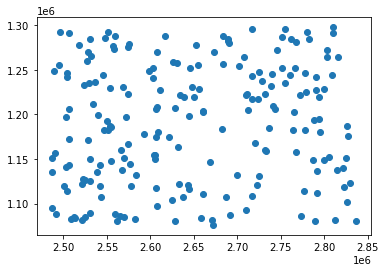

In [120]:
lat = np.random.uniform(45.82, 47.81, size=200)
lon = np.random.uniform(5.96, 10.49, size=200)

coords = WGS84Coord5(lat, lon)

plt.scatter(*coords.to_LV95());

**shapefiles für Generalisierte Kantons- / Gemeindegrenzen herunterladen**:

In [192]:
import os
import urllib
import shutil

os.makedirs("daten", exist_ok=True)

if not os.path.isdir("daten/gemeindegrenzen/"):
    print("Downloading data...")
    url = "https://www.bfs.admin.ch/bfsstatic/dam/assets/16804410/master"
    filename, headers = urllib.request.urlretrieve(url, "daten/gemeindegrenzen.zip")
    
    print("Unpacking...")
    shutil.unpack_archive("daten/gemeindegrenzen.zip", "daten/gemeindegrenzen")
    print("Removing archive...")
    os.remove("daten/gemeindegrenzen.zip")

Unpacking...
Removing archive...


In [193]:
import geopandas as gpd

kantone = gpd.read_file("daten/gemeindegrenzen/ggg_2021-LV95/shp/g1k21.shp", encoding="utf-8")
kantone = kantone[['KTNR','KTNAME','AREA_HA', 'geometry']]
kantone.head()

,KTNR,KTNAME,AREA_HA,geometry
0,1,Zürich,172894,"POLYGON ((2692443.000 1281183.000, 2692994.000..."
1,2,Bern / Berne,595951,"MULTIPOLYGON (((2573533.000 1194765.000, 25740..."
2,3,Luzern,149353,"POLYGON ((2662029.000 1237691.000, 2662264.000..."
3,4,Uri,107654,"POLYGON ((2688457.000 1203340.000, 2688740.000..."
4,5,Schwyz,90788,"POLYGON ((2704723.000 1229925.000, 2706210.000..."


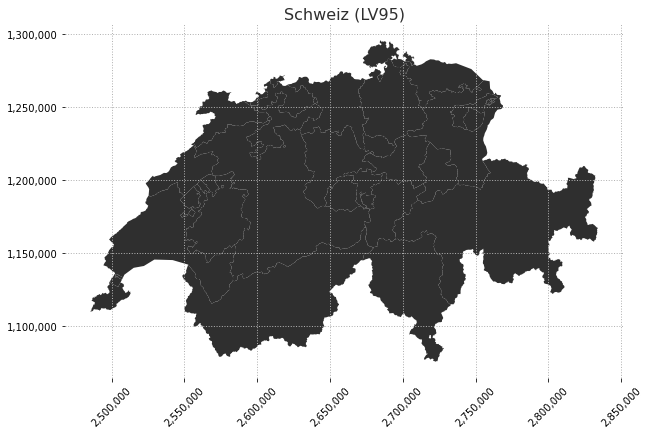

In [197]:
from matplotlib.ticker import FuncFormatter

fmt = FuncFormatter(lambda x, p: format(int(x), ','))  # Tausend-Trennzeichen in Achsen-Beschriftungen

fig, ax = plt.subplots(figsize=(10, 7))

kantone.plot(figsize=(10,7), ax=ax, fc="#2f2f2f");
ax.set_title("Schweiz (LV95)", fontsize=16, color='#2f2f2f')
ax.grid(color='#b2b2b2', linestyle=':', linewidth=1)
ax.tick_params(axis='x', rotation=45)
ax.ticklabel_format(axis='both', style='plain')
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.spines[:].set_visible(False);

In [195]:
kantone.crs

<Compound CRS: COMPD_CS["CH1903+ / LV95 + LN02 height",PROJCS["CH ...>
Name: CH1903+ / LV95 + LN02 height
Axis Info [cartesian|vertical]:
- [east]: Easting (metre)
- [north]: Northing (metre)
- [up]: Gravity-related height (metre)
Area of Use:
- undefined
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich
Sub CRS:
- CH1903+ / LV95
- LN02 height

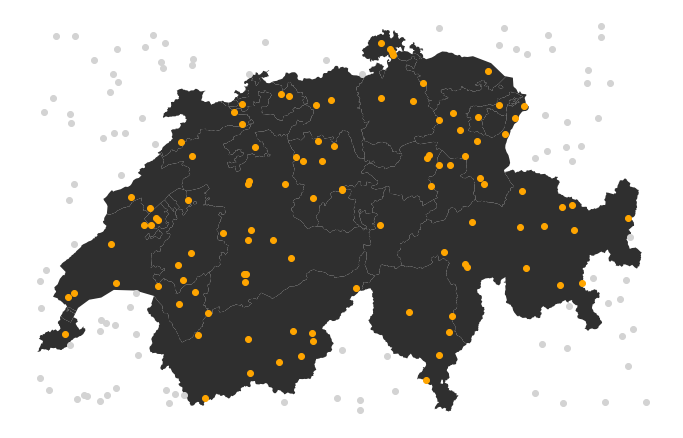

In [200]:
from shapely.geometry import Point
import matplotlib.pyplot as plt

geom = [Point(x, y) for x, y in zip(*coords.to_LV95())]
pts = gpd.GeoDataFrame(geometry=gpd.GeoSeries(geom, crs="epsg:2056"))

mask = pts.within(kantone.unary_union)

fig, ax = plt.subplots(figsize=(12,8))
kantone.plot(fc="#2f2f2f", ax=ax);
pts[mask].plot(ax=ax, fc="orange")
pts[~mask].plot(ax=ax, fc="lightgrey");
plt.axis('off');

# Aufgabe 2

Gegeben sind folgende Objekte als WKT:


```
POINT(0 0)

LINESTRING(0 0,1 1,1 2)

POLYGON((0 0,4 0,4 4,0 4,0 0),(1 1, 2 1, 2 2, 1 2,1 1))

MULTIPOINT(0 0,1 2)

MULTILINESTRING((0 0,1 1,1 2),(2 3,3 2,5 4))

MULTIPOLYGON(((0 0,4 0,4 4,0 4,0 0),(1 1,2 1,2 2,1 2,1 1)),((-1 -1,-1 -2,-2 -2,-2 -1,-1 -1)))

GEOMETRYCOLLECTION(POINT(2 3),LINESTRING((2 3,3 4)))
```

a) Berechnen Sie die Fläche der Objekte (wenn sinnvoll)<br/>
b) Berechnen Sie die Länge der Objekte (wenn sinnvoll)<br/>
c) Stellen Sie diese mit matplotlib  dar<br/>

Hinweise: 

* Dokumentation https://shapely.readthedocs.io/en/stable/
* Die Fläche lässt sich mit `object.area` berechnen
* Die Länge lässt sich mit `object.length` berechnen
* Den Geometry-Typ können Sie in Shapely mit `object.geom_type` abfragen.

In [201]:
from shapely.geometry import Polygon
from shapely import wkt

wkts = [
    "POINT(0 0)",
    "LINESTRING(0 0,1 1,1 2)",
    "POLYGON((0 0,4 0,4 4,0 4,0 0),(1 1, 2 1, 2 2, 1 2,1 1))",
    "MULTIPOINT(0 0,1 2)",
    "MULTILINESTRING((0 0,1 1,1 2),(2 3,3 2,5 4))",
    "MULTIPOLYGON(((0 0,4 0,4 4,0 4,0 0),(1 1,2 1,2 2,1 2,1 1)),((-1 -1,-1 -2,-2 -2,-2 -1,-1 -1)))",
    "GEOMETRYCOLLECTION(POINT(2 3),LINESTRING(2 3,3 4))"
]


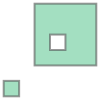

In [126]:
wkt.loads(wkts[5])

In [127]:
print(f"Geom. Type".ljust(18), f"AREA".rjust(10), f"LENGTH".rjust(10))
print("-"*40)
for wtk_str in wkts:
    geom = wkt.loads(wtk_str)
    print(f"{geom.type}".ljust(18), f"{geom.area}".rjust(10), f"{geom.length:.2f}".rjust(10))

Geom. Type               AREA     LENGTH
----------------------------------------
Point                     0.0       0.00
LineString                0.0       2.41
Polygon                  15.0      20.00
MultiPoint                0.0       0.00
MultiLineString           0.0       6.66
MultiPolygon             16.0      24.00
GeometryCollection        0.0       1.41


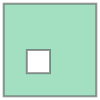

In [128]:
poly = wkt.loads(wkts[2])
poly

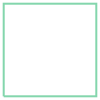

In [129]:
poly.interiors[0]

In [130]:
print(poly.length)
print(poly.exterior.length + poly.interiors[0].length) 

20.0
20.0


In [131]:
print(poly.area)
print(poly.exterior.area)      # =0 because it's a LineString
print(poly.interiors[0].area)  # same...

from shapely.geometry import Polygon

print(Polygon(poly.exterior).area - Polygon(poly.interiors[0]).area)

15.0
0.0
0.0
15.0


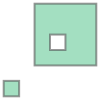

In [132]:
multipoly = wkt.loads(wkts[5])
multipoly

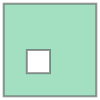

In [133]:
multipoly.geoms[0]

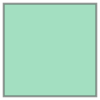

In [134]:
multipoly.geoms[1]  # ignore the scale

In [136]:
print(multipoly.area)
print(multipoly.geoms[0].area + multipoly.geoms[1].area)
print(Polygon(multipoly.geoms[0].exterior).area - Polygon(multipoly.geoms[0].interiors[0]).area + multipoly.geoms[1].area)

16.0
16.0
16.0


### Plotten mit Matplotlib

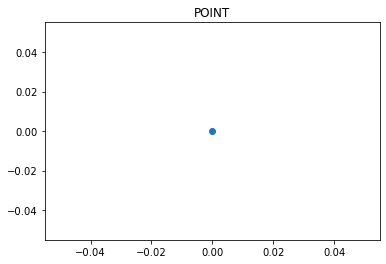

In [157]:
geom = wkt.loads(wkts[0])

plt.plot(*geom.xy, "o");
plt.title("POINT");

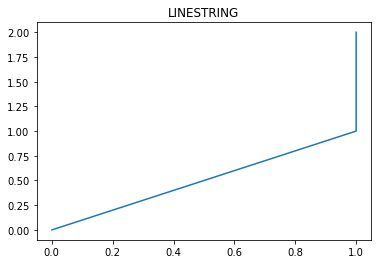

In [165]:
geom = wkt.loads(wkts[1])

plt.plot(*geom.xy, "-");
plt.title("LINESTRING");

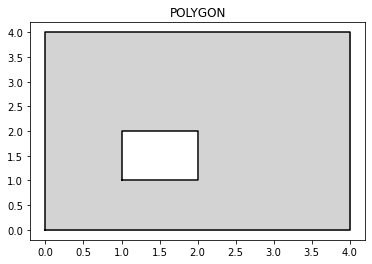

In [176]:
geom = wkt.loads(wkts[2])

plt.plot(*geom.exterior.coords.xy, "-k");
plt.fill(*geom.exterior.coords.xy, c="lightgray");

plt.plot(*geom.interiors[0].coords.xy, "-k");
plt.fill(*geom.interiors[0].coords.xy, c="w");

plt.title("POLYGON");

geht's einfacher???

## Exkurs: Rekursion
- Rekursive Funktion: Funktion, die sich selber aufruft

In [177]:
import time

def endless():
    time.sleep(0.1)
    print(".", end=" ")
    
    endless() # calls itself 

In [179]:
# Stoppen: Diese Zelle auswählen und den Interpreter stoppen
endless()

Eine rekursive Funktion braucht ein Terminationskriterium
- ein Signal das die Rekursion stoppt
- eine rekursive Funktion die an allen Elementen einer *endlichen* Liste (o.Ä.) aufgerufen wird

In [180]:
def not_so_endless(n=100):
    if n == 0:
        return
    
    time.sleep(0.1)
    print(".", end=" ")
    n -= 1
    
    not_so_endless(n)

In [181]:
not_so_endless(20)

. . . . . . . . . . . . . . . . . . . . 

- mit **Rekursion** können gewisse Probleme einfacher gelöst werden
- viele Datenstrukturen lassen sich gut mit rekursiven Methoden bearbeiten
    - verschachtelte Listen (nested lists)
    - Graphen, Baumstrukturen, ...
    - HTML DOM

**Beispiel**

In [182]:
# flatten a possibly nested list
def flatten(alist, outlist):
    for el in alist:   # die Länge der alist ist das Terminationskriterium
        if isinstance(el, list):
            flatten(el, outlist)
        else:
            outlist.append(el)
    return outlist
        

In [183]:
out = []
L = [1,2,3, [4,[5, 6], 7, 8], 9, [10]]

flatten(L, out)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [184]:
def plot_geom(geom, ax=None, figsize=(6, 6), marker='o', edgecolor='k', fillcolor='lightgray'):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if geom.geom_type == 'Point':
        ax.plot(geom.x, geom.y, marker=marker, color=edgecolor)

    elif geom.geom_type == 'LineString':
        ax.plot(*geom.coords.xy, color=edgecolor)
    
    elif geom.geom_type == 'Polygon':
        ax.plot(*geom.exterior.coords.xy, color=edgecolor)
        ax.fill(*geom.exterior.coords.xy, color=fillcolor)
        for inter in geom.interiors:
            poly = Polygon(inter)
            plot_geom(poly, ax=ax, fillcolor='w')  # Rekursion
    else:
        # Collections and Multi*
        for g in geom.geoms:
            plot_geom(g, ax=ax)   # Rekursion
            
    ax.set_title(geom.type)

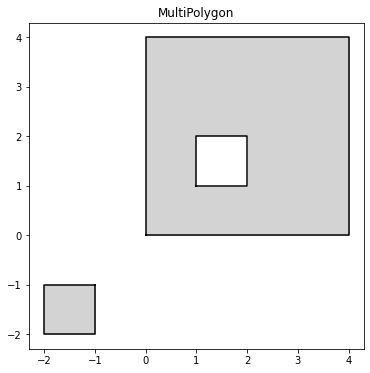

In [185]:
plot_geom(wkt.loads(wkts[5]))

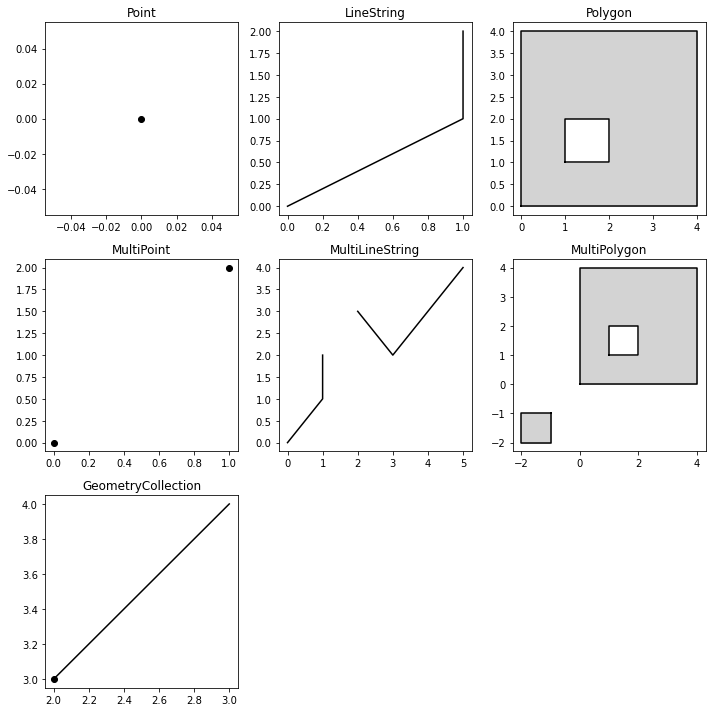

In [186]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10)) 
axes = axes.ravel()

for i, wkt_str in enumerate(wkts):
    geom = wkt.loads(wkt_str)
    plot_geom(geom, ax=axes[i])

extra_axes = len(axes) - len(wkts)

# hide last two axes
for ax in axes[-extra_axes:]:
    ax.axis('off')
plt.tight_layout()